# HW8

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mrsteamedbun/AIPI590/blob/main/HW8/hw8.ipynb)

Null Hypothesis (H0):

The ResNet50 model does not show a significant difference in the saliency maps between sharp and blurry images of dogs. Specifically, the model's focus areas remain consistent regardless of image sharpness.

Alternative Hypothesis (H1):

The ResNet50 model shows a significant difference in the saliency maps between sharp and blurry images of dogs. Specifically, image blurriness affects the model's focus areas in the saliency maps.

In [3]:
!pip install numpy==1.25.2 matplotlib==3.7.1 tensorflow==2.14.1 tensorflow_datasets==4.9.2 opencv-python-headless

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import get_file
import json
import cv2

In [5]:
def generate_saliency_map(model, img):
    x = tf.Variable(img)
    x = tf.expand_dims(x, axis=0)
    x = preprocess_input(x)
    with tf.GradientTape() as tape:
        tape.watch(x)
        preds = model(x)
        top_pred_index = tf.argmax(preds[0])
        top_class_score = preds[0][top_pred_index]
    grads = tape.gradient(top_class_score, x)
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]
    return saliency.numpy(), top_pred_index.numpy()

def get_dog_images(num_images):
    dataset = tfds.load('imagenet_v2', split='test', as_supervised=True)
    dog_images = []
    dog_labels = []
    dog_class_indices = [int(key) for key, value in class_idx.items() if 'dog' in value[1]]
    for img, label in dataset:
        if label.numpy() in dog_class_indices:
            img = tf.image.resize(img, (224, 224))
            img = img.numpy().astype(np.float32)
            dog_images.append(img)
            dog_labels.append(label.numpy())
            if len(dog_images) >= num_images:
                break
    return dog_images, dog_labels

def normalize(saliency):
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-8)
    return saliency

In [6]:
# Load ResNet50
model = tf.keras.applications.ResNet50(weights='imagenet', include_top=True)

class_index_path = get_file('imagenet_class_index.json', 'https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json')
with open(class_index_path) as f:
    class_idx = json.load(f)

In [8]:
num_images = 5
images, labels = get_dog_images(num_images)

kernel = np.array([[-1,-1,-1],
                       [-1, 9,-1],
                       [-1,-1,-1]])

sharp_images = [cv2.filter2D(img, -1, kernel) for img in images]
blurry_images = [cv2.GaussianBlur(img, (15, 15), 0) for img in images]

sharp_saliency_maps = []
blurry_saliency_maps = []
predicted_classes = []

for img in sharp_images:
    saliency_map, top_pred_index = generate_saliency_map(model, img)
    sharp_saliency_maps.append(saliency_map)
    predicted_classes.append(class_idx[str(top_pred_index)][1])

for img in blurry_images:
    saliency_map, _ = generate_saliency_map(model, img)
    blurry_saliency_maps.append(saliency_map)

sharp_saliency_maps = [normalize(s) for s in sharp_saliency_maps]
blurry_saliency_maps = [normalize(s) for s in blurry_saliency_maps]

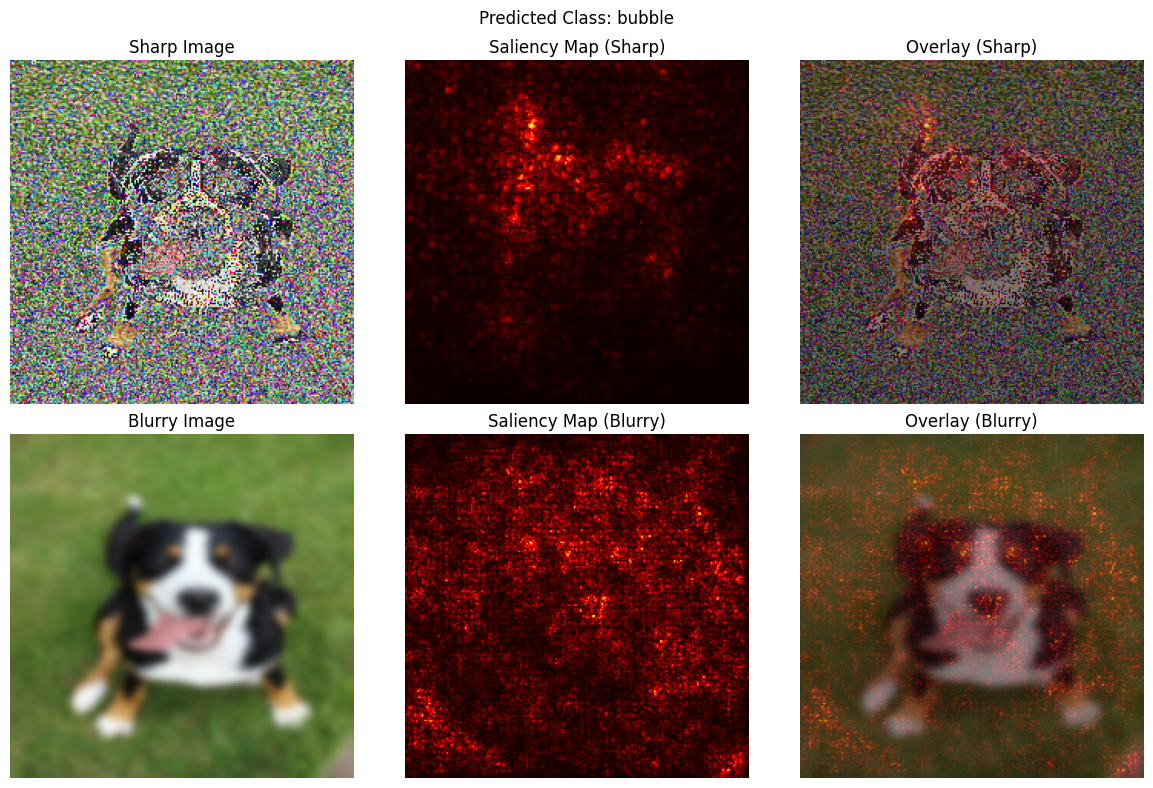

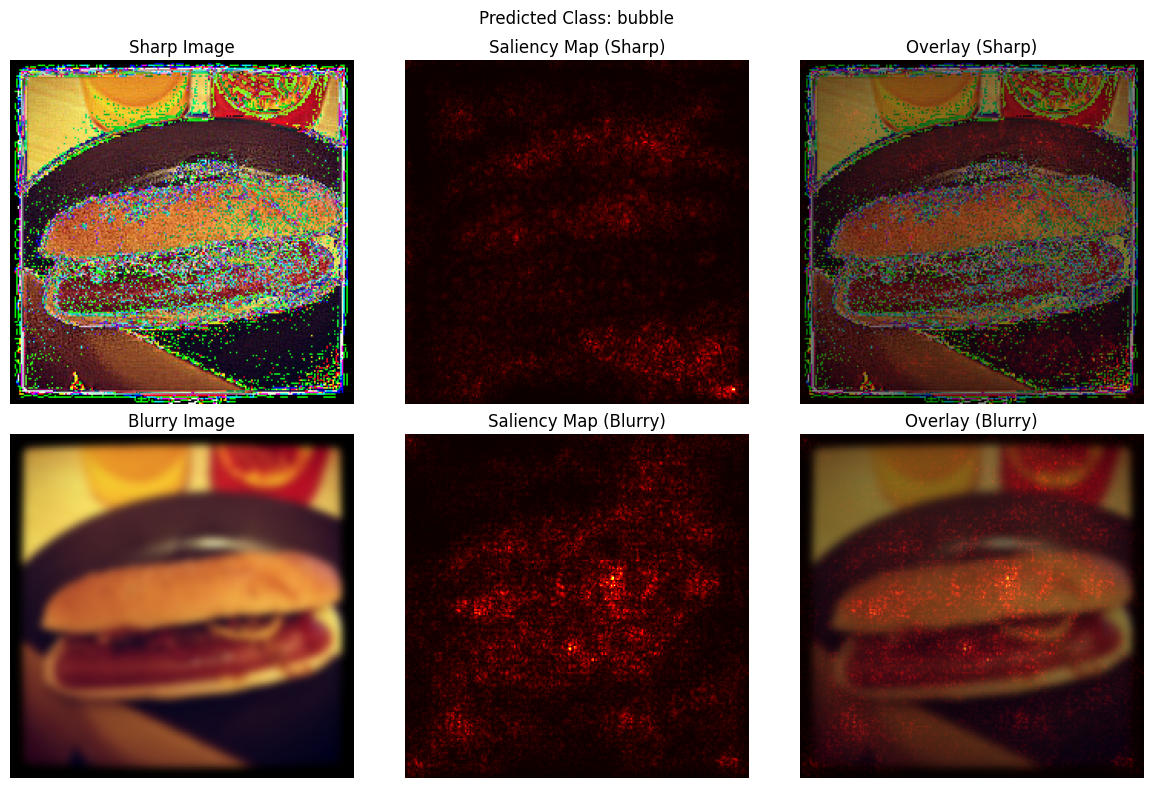

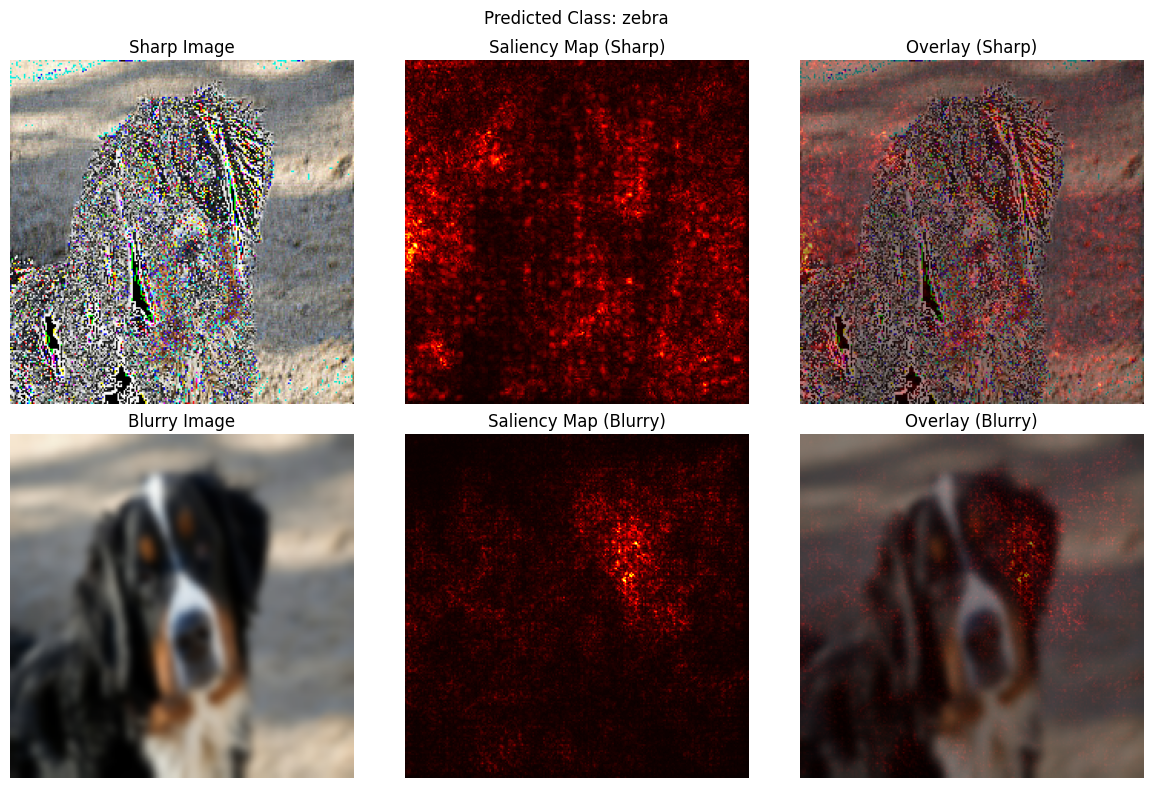

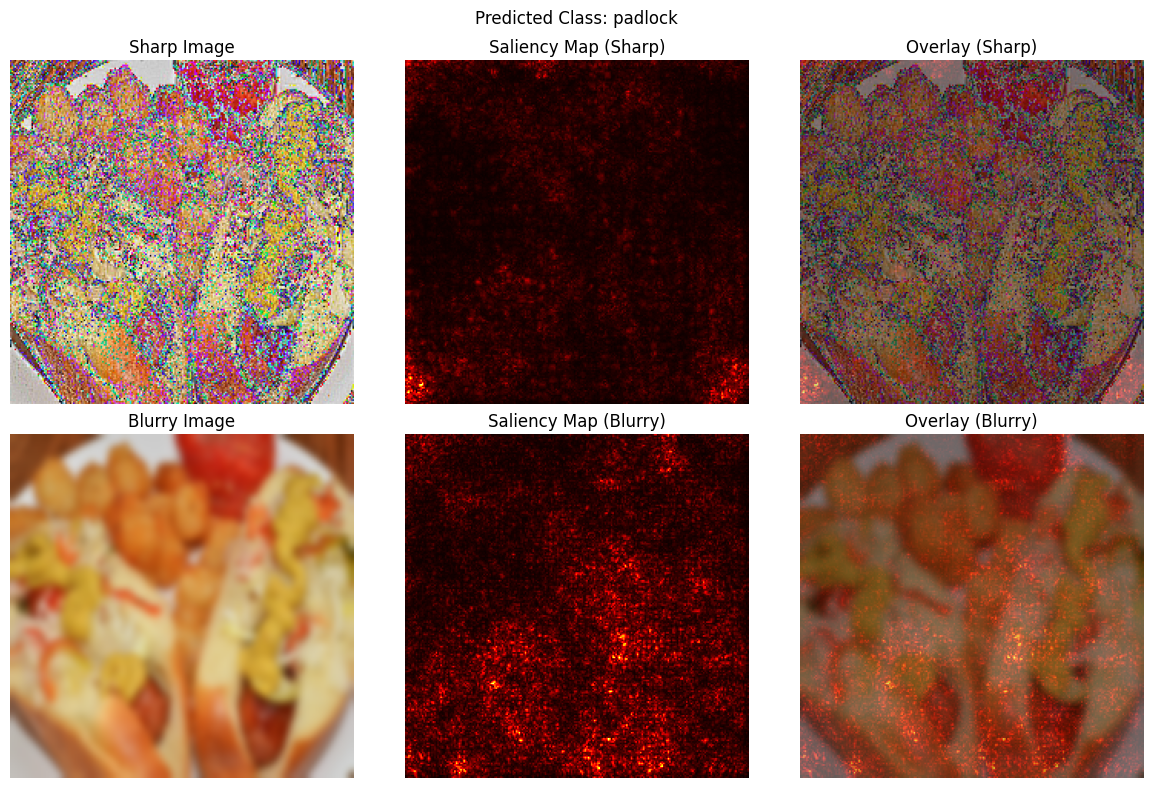

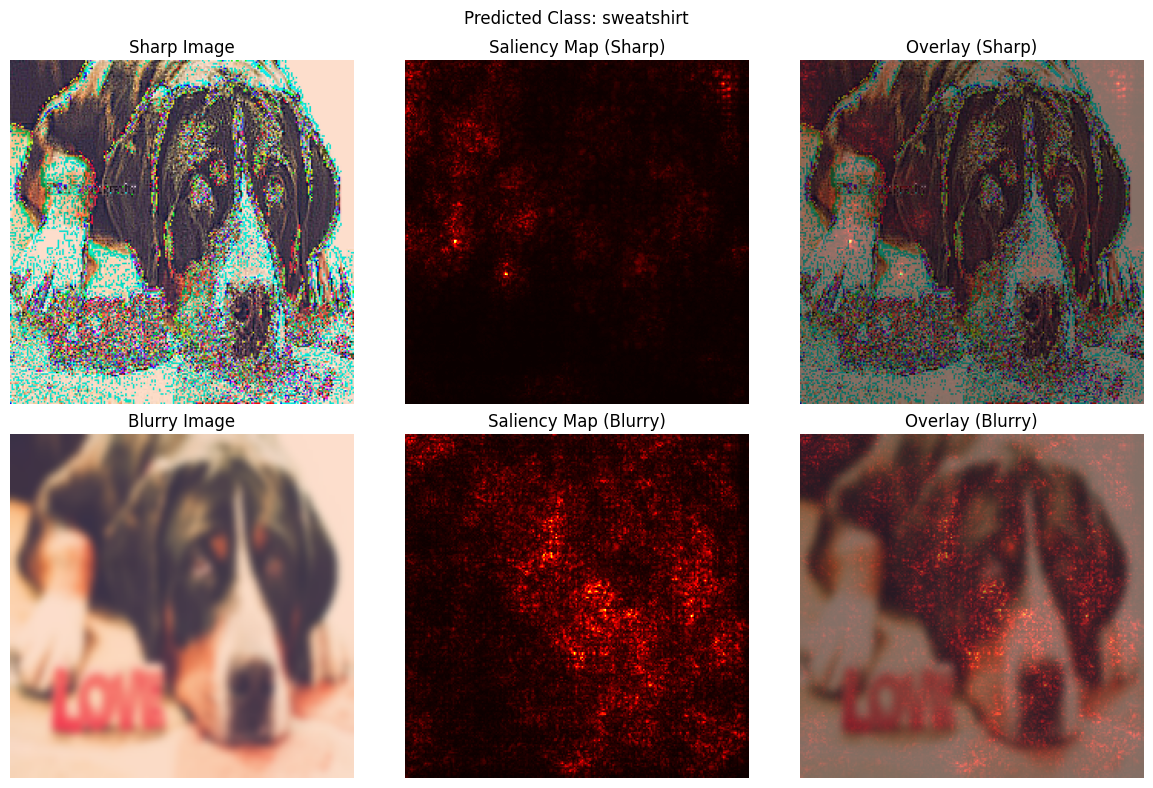

In [9]:
for i in range(num_images):
    plt.figure(figsize=(12, 8))

    # Sharp image
    plt.subplot(2, 3, 1)
    plt.imshow(sharp_images[i].astype(np.uint8))
    plt.title('Sharp Image')
    plt.axis('off')

    # Saliency map for sharp image
    plt.subplot(2, 3, 2)
    plt.imshow(sharp_saliency_maps[i], cmap='hot')
    plt.title('Saliency Map (Sharp)')
    plt.axis('off')

    # Overlay saliency map on sharp image
    plt.subplot(2, 3, 3)
    plt.imshow(sharp_images[i].astype(np.uint8))
    plt.imshow(sharp_saliency_maps[i], cmap='hot', alpha=0.5)
    plt.title('Overlay (Sharp)')
    plt.axis('off')

    # Blurry image
    plt.subplot(2, 3, 4)
    plt.imshow(blurry_images[i].astype(np.uint8))
    plt.title('Blurry Image')
    plt.axis('off')

    # Saliency map for blurry image
    plt.subplot(2, 3, 5)
    plt.imshow(blurry_saliency_maps[i], cmap='hot')
    plt.title('Saliency Map (Blurry)')
    plt.axis('off')

    # Overlay saliency map on blurry image
    plt.subplot(2, 3, 6)
    plt.imshow(blurry_images[i].astype(np.uint8))
    plt.imshow(blurry_saliency_maps[i], cmap='hot', alpha=0.5)
    plt.title('Overlay (Blurry)')
    plt.axis('off')

    plt.suptitle(f"Predicted Class: {predicted_classes[i]}")
    plt.tight_layout()
    plt.show()